In [122]:
import pandas as pd
import numpy as np
#from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import accuracy_score, confusion_matrix
import shap

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import train_test_split
from sklearn import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV files
rankings_df = pd.read_csv('rankings.csv')
matches_df = pd.read_csv('matches.csv')
players_df = pd.read_csv('players.csv')

# Display the first few rows of each dataframe to understand the structure
print("Rankings:")
print(rankings_df.head())
print("Matches:")
print(matches_df.head())
print("Players:")
print(players_df.head())

ModuleNotFoundError: No module named 'shap'

In [98]:
# Check the summary of each dataframe
print(rankings_df.info())
print(matches_df.info())
print(players_df.info())
print(matches_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113261 entries, 0 to 3113260
Data columns (total 4 columns):
 #   Column        Dtype  
---  ------        -----  
 0   ranking_date  int64  
 1   rank          int64  
 2   player        int64  
 3   points        float64
dtypes: float64(1), int64(3)
memory usage: 95.0 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188161 entries, 0 to 188160
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          188161 non-null  object 
 1   tourney_name        188161 non-null  object 
 2   surface             185844 non-null  object 
 3   draw_size           188161 non-null  int64  
 4   tourney_level       188161 non-null  object 
 5   tourney_date        188161 non-null  int64  
 6   match_num           188161 non-null  int64  
 7   winner_id           188161 non-null  int64  
 8   winner_seed         69694 non-null   float64
 9   winn

In [99]:
matches_df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

Text(0.5, 1.0, '10 Top players')

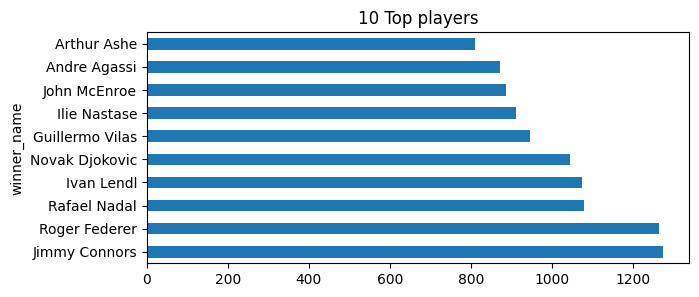

In [100]:
plt.figure(figsize=(7,3))
matches_df['winner_name'].value_counts()[:10].plot(kind='barh')
plt.title('10 Top players')

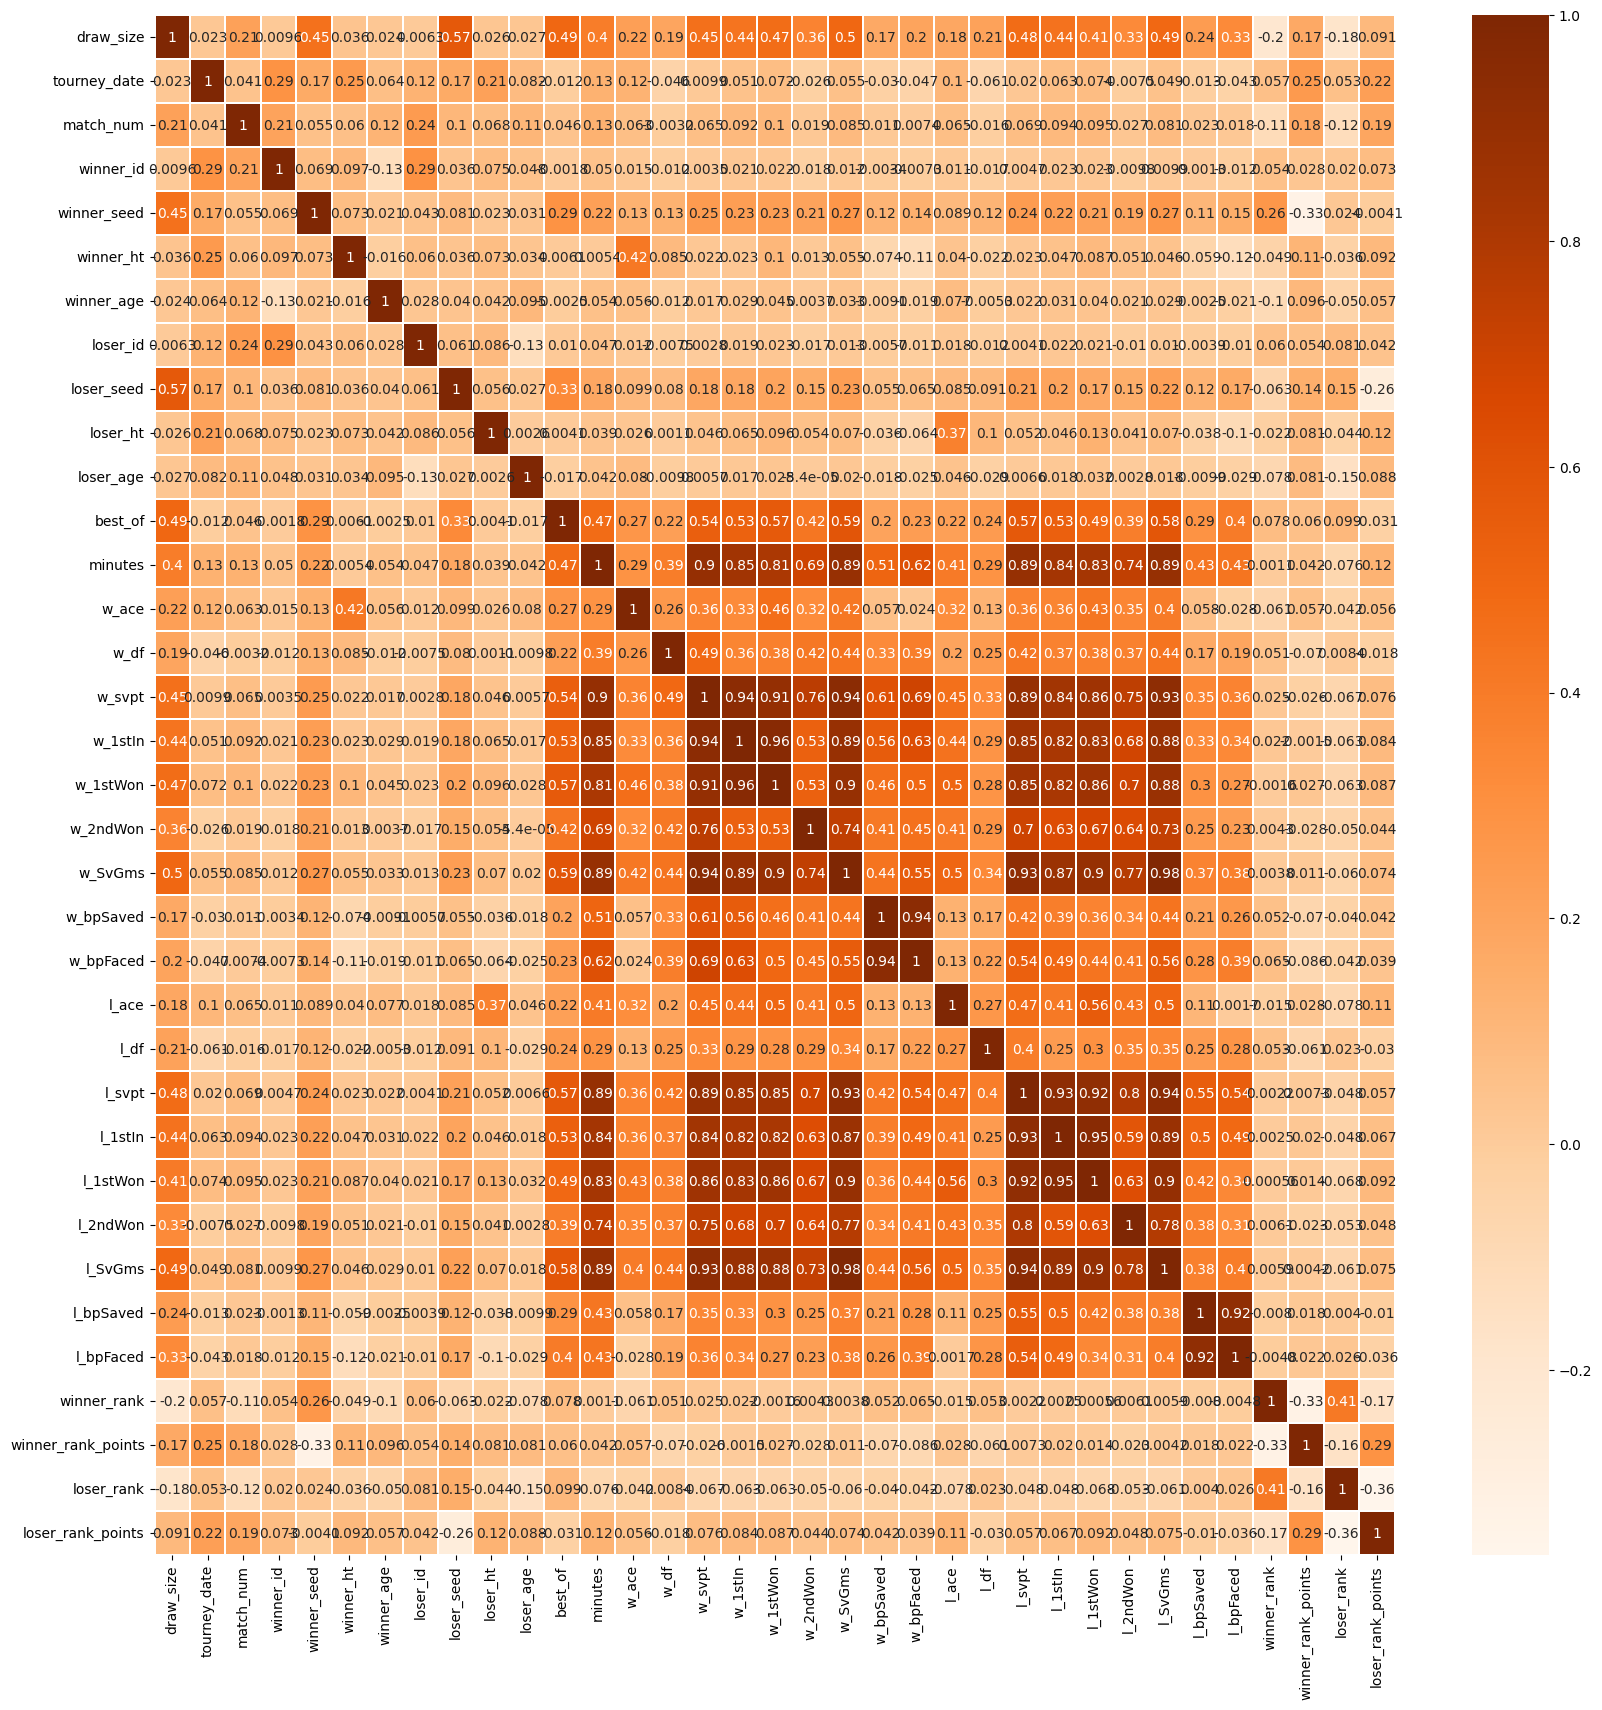

In [101]:
# Select only numeric columns for correlation
numeric_df = matches_df.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, linewidth=0.1, cmap='Oranges')
plt.show()


In [102]:
ddf = matches_df.drop(columns=['score','tourney_name','winner_name',
                      'loser_name','minutes', 'l_1stIn', 'l_1stWon', 'l_2ndWon','l_ace', 'l_svpt',
                      'l_SvGms','l_bpFaced','l_df', 'l_bpSaved',  'w_1stIn', 'w_1stWon','w_2ndWon', 'w_SvGms',
                      'w_ace', 'w_svpt','w_bpFaced', 'w_bpSaved','w_df', 'draw_size'])
print("remained features ", ddf.columns)

remained features  Index(['tourney_id', 'surface', 'tourney_level', 'tourney_date', 'match_num',
       'winner_id', 'winner_seed', 'winner_entry', 'winner_hand', 'winner_ht',
       'winner_ioc', 'winner_age', 'loser_id', 'loser_seed', 'loser_entry',
       'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'best_of', 'round',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')


In [103]:
none_percent = ddf.isnull().sum() * 100 / len(ddf)
none_values_df = pd.DataFrame({'Feature name': ddf.columns, 'None values count': ddf.isnull().sum(),
                                 'None values percent': none_percent})
print(none_values_df.reset_index().drop(columns=['index']))

          Feature name  None values count  None values percent
0           tourney_id                  0             0.000000
1              surface               2317             1.231392
2        tourney_level                  0             0.000000
3         tourney_date                  0             0.000000
4            match_num                  0             0.000000
5            winner_id                  0             0.000000
6          winner_seed             118467            62.960443
7         winner_entry             171891            91.353150
8          winner_hand                 17             0.009035
9            winner_ht              16237             8.629312
10          winner_ioc                 10             0.005315
11          winner_age               1335             0.709499
12            loser_id                  0             0.000000
13          loser_seed             152824            81.219806
14         loser_entry             160432            85

In [104]:
remove = none_values_df[none_values_df['None values percent'] > 85]
print(remove)
ddf = ddf.drop(columns=remove['Feature name'].values)
print("Remaining values")
print(ddf.columns)


              Feature name  None values count  None values percent
winner_entry  winner_entry             171891            91.353150
loser_entry    loser_entry             160432            85.263152
Remaining values
Index(['tourney_id', 'surface', 'tourney_level', 'tourney_date', 'match_num',
       'winner_id', 'winner_seed', 'winner_hand', 'winner_ht', 'winner_ioc',
       'winner_age', 'loser_id', 'loser_seed', 'loser_hand', 'loser_ht',
       'loser_ioc', 'loser_age', 'best_of', 'round', 'winner_rank',
       'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')


In [105]:
ddf.dropna(subset=['surface', 'winner_rank','loser_rank','winner_rank_points', 'loser_rank_points'], inplace=True)
ddf = ddf.reset_index(drop=True)
print(ddf.info)

<bound method DataFrame.info of                               tourney_id surface tourney_level  tourney_date  \
0                               1973-303    Clay             A      19731125   
1                               1973-303    Clay             A      19731125   
2                               1973-303    Clay             A      19731125   
3                               1973-303    Clay             A      19731125   
4                               1973-303    Clay             A      19731125   
...                                  ...     ...           ...           ...   
103584  2022-M-DC-2022-WG2-PO-GRE-JAM-01    Clay             D      20220304   
103585  2022-M-DC-2022-WG2-PO-GRE-JAM-01    Clay             D      20220304   
103586  2022-M-DC-2022-WG2-PO-GRE-JAM-01    Clay             D      20220304   
103587  2022-M-DC-2022-WG2-PO-GRE-JAM-01    Clay             D      20220304   
103588  2022-M-DC-2022-WG2-PO-HKG-BEN-01    Hard             D      20220304   

       

In [106]:
ddf['tourney_year'] = ddf.tourney_date.astype(str).str[:4].astype(int)
ddf['tourney_month'] = ddf.tourney_date.astype(str).str[4:6].astype(int)
ddf = ddf.drop(columns=['tourney_date'])
print(ddf.info)

<bound method DataFrame.info of                               tourney_id surface tourney_level  match_num  \
0                               1973-303    Clay             A          5   
1                               1973-303    Clay             A         18   
2                               1973-303    Clay             A         19   
3                               1973-303    Clay             A         21   
4                               1973-303    Clay             A         22   
...                                  ...     ...           ...        ...   
103584  2022-M-DC-2022-WG2-PO-GRE-JAM-01    Clay             D          1   
103585  2022-M-DC-2022-WG2-PO-GRE-JAM-01    Clay             D          2   
103586  2022-M-DC-2022-WG2-PO-GRE-JAM-01    Clay             D          4   
103587  2022-M-DC-2022-WG2-PO-GRE-JAM-01    Clay             D          5   
103588  2022-M-DC-2022-WG2-PO-HKG-BEN-01    Hard             D          1   

        winner_id  winner_seed winner_hand 

In [107]:
ddf = ddf.rename(columns={"loser_age": "first_age", "loser_entry": "first_entry", "loser_hand": "first_hand",
                        "loser_ht": "first_ht", "loser_id": "first_id", "loser_ioc": "first_ioc",
                        "loser_rank": "first_rank", "loser_rank_points": "first_rank_points",
                        "loser_seed": "first_seed",
                
                        "winner_age": "second_age", "winner_entry": "second_entry","winner_hand": "second_hand",
                        "winner_ht": "second_ht", "winner_id": "second_id", "winner_ioc": "second_ioc",
                        "winner_rank": "second_rank", "winner_rank_points": "second_rank_points",
                        "winner_seed": "second_seed",
                       },)
copy_2_ddf = ddf.copy()
copy_2_ddf[[ 'first_age','first_hand','first_ht','first_id','first_ioc','first_rank','first_rank_points','first_seed',
            'second_age','second_hand','second_ht','second_id','second_ioc','second_rank','second_rank_points','second_seed']]\
=copy_2_ddf[['second_age','second_hand','second_ht','second_id','second_ioc','second_rank','second_rank_points','second_seed',
             'first_age','first_hand','first_ht','first_id','first_ioc','first_rank','first_rank_points','first_seed']]

winner_player2 = np.zeros(ddf.shape[0]) # second player wins so label = 0
ddf['label'] = winner_player2


winner_player1 = np.ones(copy_2_ddf.shape[0]) # first player wins so label = 1
copy_2_ddf['label'] = winner_player1 

ddf = pd.concat([ddf,copy_2_ddf])
#shuffle data... fraction 1 just means return every value but in a random order
ddf = ddf.sample(frac=1).reset_index(drop=True)

print(ddf)
print(ddf.columns)
print(copy_2_ddf)

       tourney_id surface tourney_level  match_num  second_id  second_seed  \
0        2003-414    Clay             M         13     102856         11.0   
1       2022-0315   Grass             A        278     104918          6.0   
2        1992-404    Hard             M         16     101320         13.0   
3        1997-505    Clay             A         14     102024          NaN   
4        1994-428  Carpet             A         25     102021          6.0   
...           ...     ...           ...        ...        ...          ...   
207173  2017-7650   Grass             A        290     104947          NaN   
207174   1992-367    Clay             A         23     101806          NaN   
207175  2007-1720    Hard             A         18     103821          NaN   
207176   1998-339    Hard             A         15     101601          NaN   
207177   1991-315   Grass             A         14     101932          NaN   

       second_hand  second_ht second_ioc  second_age  ...  firs

In [108]:
hand_encoder = LabelEncoder()
ddf['first_hand'] = hand_encoder.fit_transform(ddf['first_hand'].astype(str))
ddf['second_hand'] = hand_encoder.transform(ddf['second_hand'].astype(str))

ddf['first_ioc'] = LabelEncoder().fit_transform(ddf['first_ioc'].astype(str))
ddf['second_ioc'] = LabelEncoder().fit_transform(ddf['second_ioc'].astype(str))

#ddf['surface'] = LabelBinarizer().fit_transform(df['surface'].astype(str))
ddf['tourney_level'] = LabelEncoder().fit_transform(ddf['tourney_level'].astype(str))
ddf['tourney_id'] = LabelEncoder().fit_transform(ddf['tourney_id'].astype(str))
ddf['round'] = LabelEncoder().fit_transform(ddf['round'].astype(str))
ddf = pd.get_dummies(ddf, columns=['surface'], drop_first=False)
ddf = ddf.astype({col: 'int' for col in ddf.select_dtypes('bool').columns})

ddf.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207178 entries, 0 to 207177
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          207178 non-null  int64  
 1   tourney_level       207178 non-null  int64  
 2   match_num           207178 non-null  int64  
 3   second_id           207178 non-null  int64  
 4   second_seed         66071 non-null   float64
 5   second_hand         207178 non-null  int64  
 6   second_ht           202441 non-null  float64
 7   second_ioc          207178 non-null  int64  
 8   second_age          207092 non-null  float64
 9   first_id            207178 non-null  int64  
 10  first_seed          66071 non-null   float64
 11  first_hand          207178 non-null  int64  
 12  first_ht            202441 non-null  float64
 13  first_ioc           207178 non-null  int64  
 14  first_age           207092 non-null  float64
 15  best_of             207178 non-nul

In [109]:
ddf_imputed = pd.DataFrame(SimpleImputer().fit_transform(ddf))
ddf_imputed.columns = ddf.columns
ddf_imputed.index = ddf.index
ddf = ddf_imputed.copy()

In [110]:
print('Final shape of data after cleaning and preprocessing: ', ddf.shape)

Final shape of data after cleaning and preprocessing:  (207178, 28)


In [111]:
y = ddf['label']
ddf_X = ddf.drop(columns='label')

In [112]:
# split data : 80% for train and 20% for test.
X_train, X_test, y_train, y_test = train_test_split(ddf_X, y, test_size=0.2)

In [113]:
#Call the classifier
RF_classifier = RandomForestClassifier(n_estimators=100)
#fit the data
RF_classifier.fit(X_train, y_train)
#predict 
RF_predictions = RF_classifier.predict(X_test)

In [114]:
print('Confusion matrix')
print(confusion_matrix(y_test,RF_predictions))
print('Classification report')
print(classification_report(y_test,RF_predictions))
print('Accuracy= ', accuracy_score(y_test, RF_predictions))

Confusion matrix
[[13530  7224]
 [ 7585 13097]]
Classification report
              precision    recall  f1-score   support

         0.0       0.64      0.65      0.65     20754
         1.0       0.64      0.63      0.64     20682

    accuracy                           0.64     41436
   macro avg       0.64      0.64      0.64     41436
weighted avg       0.64      0.64      0.64     41436

Accuracy=  0.6426054638478618


In [115]:
#Call the classifier
XGB_classifier = XGBClassifier()
#fit the data
XGB_classifier.fit(X_train, y_train)
#predict 
XGB_predictions = XGB_classifier.predict(X_test)

In [116]:
print('Confusion matrix')
print(confusion_matrix(y_test,XGB_predictions))
print('Classification report')
print(classification_report(y_test,XGB_predictions))
print('Accuracy= ', accuracy_score(y_test, XGB_predictions))

Confusion matrix
[[13777  6977]
 [ 6975 13707]]
Classification report
              precision    recall  f1-score   support

         0.0       0.66      0.66      0.66     20754
         1.0       0.66      0.66      0.66     20682

    accuracy                           0.66     41436
   macro avg       0.66      0.66      0.66     41436
weighted avg       0.66      0.66      0.66     41436

Accuracy=  0.6632879621585095


In [117]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(XGB_classifier)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], matplotlib=True)

NameError: name 'shap' is not defined

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)